In [1]:
%env CUDA_VISIBLE_DEVICES=3
%env TRANSFORMERS_CACHE=/mnt/LLM/hub
%env HF_HOME=/mnt/LLM/hub
%env OMP_NUM_THREADS=16

import os
import sys
sys.path.insert(0, '..')

import time
import random
from tqdm.auto import trange
import ipynbname  # pip install ipynbname
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers

from src.aq import QuantizedWeight
from src.utils import get_mean_nbits_by_codebook
import huffman


torch.set_num_threads(16)
torch.backends.cudnn.allow_tf32 = False
torch.backends.cuda.matmul.allow_tf32 = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_loading_dir = '/extra_disk_1/vahe1994/BRRR/layer10.self_attn.q_proj.input_activation.pt'  # <-- stealing from Vahe
num_codebooks = 2
nbits_per_codebook = 8
out_group_size = 1
in_group_size = 8
batch_size = 16384
beam_size = 1
beam_search_epochs = 100
print_frequency = 10
scale_out_group_size = 1
scale_in_group_size = 32
scale_nbits = 16    # 0 means no scales, 16 means no compression;
codebook_values_nbits = 16  # less than 16 means we quantize codebooks as well
init_max_iter = 100
info_regularizer = 10.0
info_warmup_epochs = 0



env: CUDA_VISIBLE_DEVICES=3
env: TRANSFORMERS_CACHE=/mnt/LLM/hub
env: HF_HOME=/mnt/LLM/hub
env: OMP_NUM_THREADS=16


/home/jheuristic/anaconda3/lib/python3.9/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
import wandb

os.environ["WANDB_NOTEBOOK_NAME"] = os.path.join(os.getcwd(), ipynbname.name() + ".ipynb")

# start a new wandb run to track this script
run = wandb.init(
    # set the wandb project where this run will be logged
    dir=os.getcwd(),
    project="AddQuantization",
    entity = "rock-and-roll",
    save_code=True,
    name = f"{ipynbname.name()}_AQ_{num_codebooks=}_{out_group_size=}_{in_group_size=}_{nbits_per_codebook=}_{beam_search_epochs=}",
    settings=wandb.Settings(code_dir="."),
    # track hyperparameters and run metadata
    config={
    "num_codebooks" : num_codebooks,
    "out_group_size": out_group_size,
    "in_group_size": in_group_size,
    "group_size" : out_group_size * in_group_size,
    "batch_size" : batch_size,
    "beam_size" : beam_size,
    "nbits_per_codebook" : nbits_per_codebook,
    "codebook_values_nbits": codebook_values_nbits,
    "scale_nbits": scale_nbits,
    "beam_search_epochs": beam_search_epochs,
    "init_max_iter": init_max_iter,
    "info_regularizer": info_regularizer,
      "scale_out_group_size": scale_out_group_size,
      "scale_in_group_size": scale_in_group_size,
    }
)

wandb: Currently logged in as: justheuristic (rock-and-roll). Use `wandb login --relogin` to force relogin


wandb: WARNING No relevant files were detected in the specified directory. No code will be logged to your run.


In [3]:
model = transformers.AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-70b-hf", torch_dtype='auto', low_cpu_mem_usage=True)

X = torch.load(input_loading_dir, map_location='cpu').float().flatten(0, -2)
reference_weight = model.model.layers[10].self_attn.q_proj.weight.detach().to(device).float()

XTX = torch.zeros(X.shape[-1], X.shape[-1], device=device, dtype=torch.float64)
for i in range(0, len(X), batch_size):
    x_batch = X[i: i + batch_size].cuda().double()
    XTX.addmm_(x_batch.T, x_batch, alpha=1/len(X))
    del x_batch
XTX = XTX.float()
del X

Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

In [6]:
def _calculate_code_frequencies(codes: torch.LongTensor):
    code_counts = torch.zeros(num_codebooks, 2**nbits_per_codebook, dtype=torch.int64, device=codes.device)
    for codebook_index in range(num_codebooks):
        code_counts[codebook_index, :] = torch.bincount(
            codes[..., codebook_index].flatten(), minlength=2**nbits_per_codebook)
    return code_counts.float() / code_counts.sum(-1, keepdim=True)

def _calculate_code_entropy(codes: torch.LongTensor, eps: float = 1e-20):
    """Calculate per-codebook code entropy measured in bits (base-2)"""
    probs = _calculate_code_frequencies(codes)
    logprobs = torch.log2(probs.clamp_min(eps))
    return - torch.sum(probs * logprobs, dim=-1)

def _get_huffman_penalties_upper_bound(codes: torch.LongTensor, regularizer: float):
    """Compute log-probability penalties that minimize a linearized upper bound on entropy """
    penalties = torch.empty(num_codebooks, 2 ** nbits_per_codebook, device=codes.device, dtype=torch.float32)
    freqs = _calculate_code_frequencies(codes)
    
    for codebook_index in range(num_codebooks):
        num_codes = torch.as_tensor(codes[..., codebook_index].numel(), device=probs.device)
        missing_value_length = torch.log2(num_codes).item()
        
        huffman_codes = huffman.codebook([(i, freqs[codebook_index, i].item()) for i in range(2 ** nbits_per_codebook)])
        code_lengths = torch.as_tensor([
            len(huffman_codes.get(i, missing_value_length)) for i in range(2 ** nbits_per_codebook)],
            device=freqs.device, dtype=torch.float32)
        penalties[codebook_index] = (regularizer / num_codes) * code_lengths
    return penalties

def _get_entropy_penalties_upper_bound(codes: torch.LongTensor, regularizer: float):
    """Compute log-probability penalties that minimize a linearized upper bound on entropy """
    probs = _calculate_code_frequencies(codes)
    num_codes = torch.as_tensor(codes[..., 0].numel(), device=probs.device)
    logprobs = torch.log2(probs.clamp_min(1. / num_codes))
    return (- regularizer / num_codes) * logprobs 


# Main calibration code

loss=0.0112776970	 time_on_epoch 0 = 0.15392981516197324
loss=0.0104061036	 time_on_epoch 10 = 0.13911815220490098
loss=0.0096686438	 time_on_epoch 20 = 0.13940292270854115
loss=0.0090408070	 time_on_epoch 30 = 0.13929280312731862
loss=0.0085030877	 time_on_epoch 40 = 0.13954856293275952
loss=0.0080399071	 time_on_epoch 50 = 0.13907878287136555
loss=0.0076387553	 time_on_epoch 60 = 0.13979484187439084
loss=0.0072895311	 time_on_epoch 70 = 0.14045515283942223
loss=0.0069840294	 time_on_epoch 80 = 0.13922056183218956
loss=0.0067155460	 time_on_epoch 90 = 0.13974304217845201
Entropy before beam search: 7.9963178634643555


  0%|          | 0/2048 [00:00<?, ?it/s]

Entropy after beam search: 7.981380462646484
saved to /home/jheuristic/AQLM_entropy/notebooks/aq_entropy.pdf


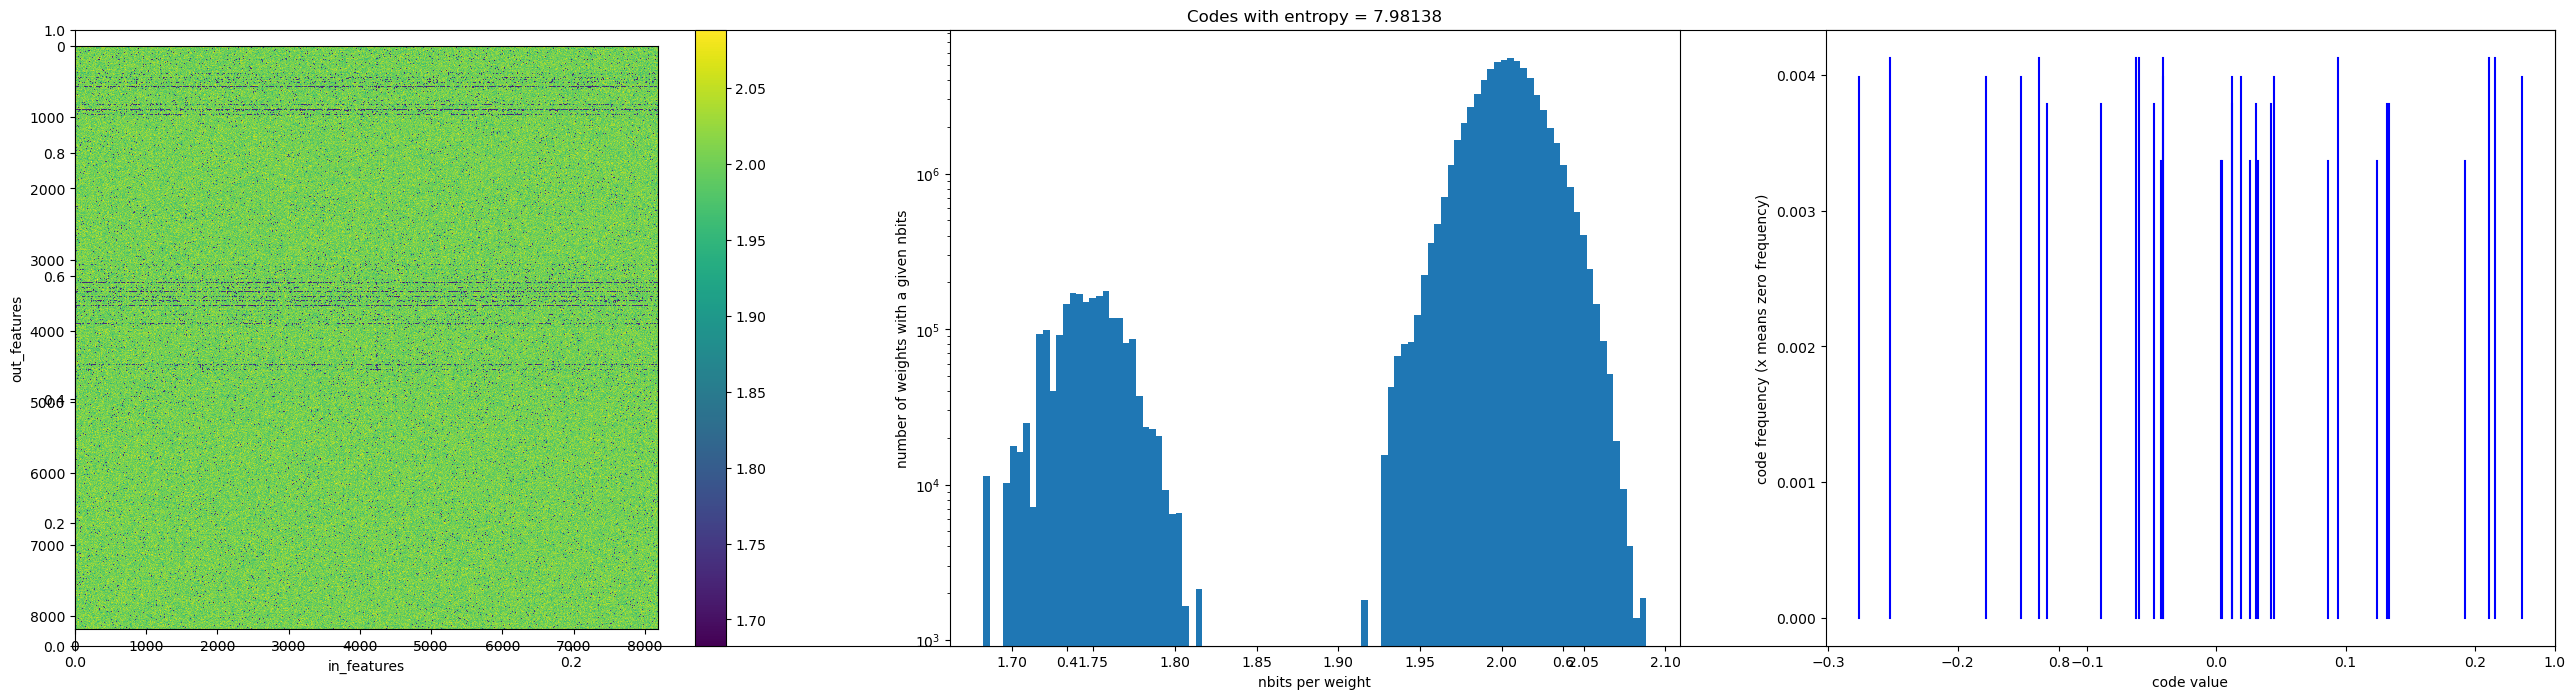

mean_code_nbits 7.99266
loss=0.0032557626	 time_on_epoch 100 = 0.1541226441040635
loss=0.0032456837	 time_on_epoch 110 = 0.14064636174589396
loss=0.0032375223	 time_on_epoch 120 = 0.1399134318344295
loss=0.0032305140	 time_on_epoch 130 = 0.14016761211678386
loss=0.0032243587	 time_on_epoch 140 = 0.1403505909256637
loss=0.0032188803	 time_on_epoch 150 = 0.14025286119431257
loss=0.0032139544	 time_on_epoch 160 = 0.14038309222087264
loss=0.0032094873	 time_on_epoch 170 = 0.14086728123947978
loss=0.0032054066	 time_on_epoch 180 = 0.14048142125830054
loss=0.0032016550	 time_on_epoch 190 = 0.13974572205916047
Entropy before beam search: 7.981380462646484


  0%|          | 0/2048 [00:00<?, ?it/s]

Entropy after beam search: 7.9251627922058105
saved to /home/jheuristic/AQLM_entropy/notebooks/aq_entropy.pdf


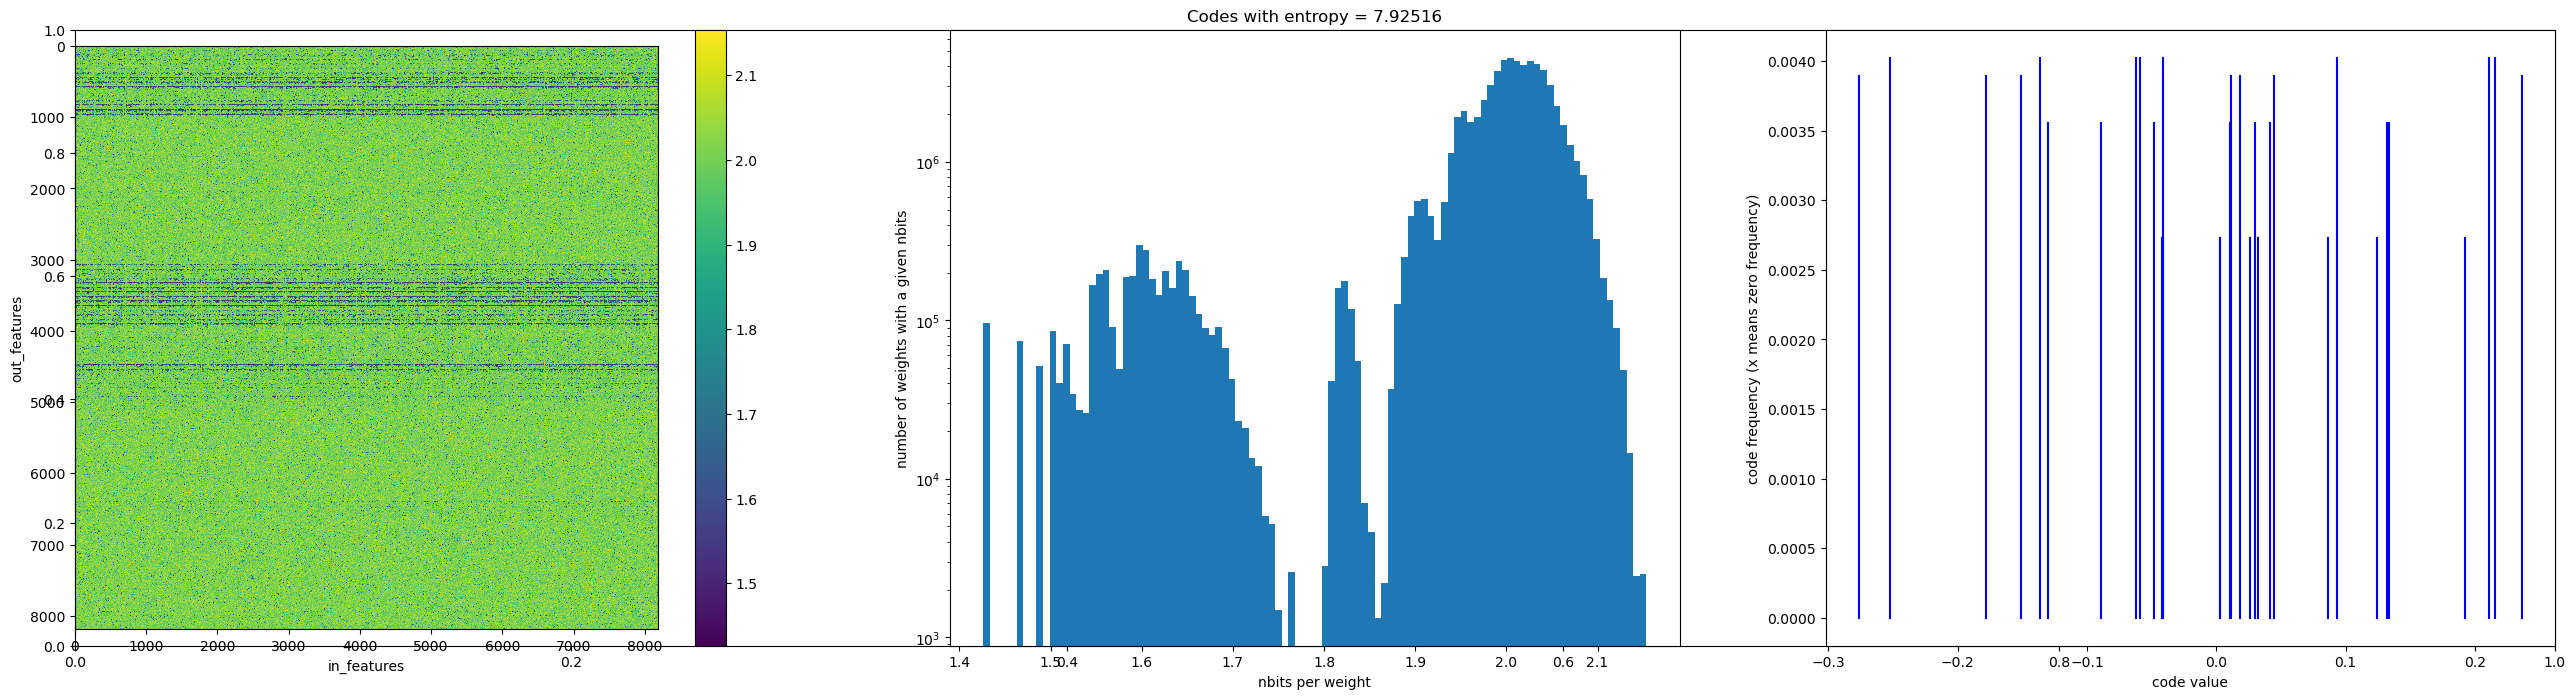

mean_code_nbits 7.94920
loss=0.0027257958	 time_on_epoch 200 = 0.15654660295695066
loss=0.0027194570	 time_on_epoch 210 = 0.14383251080289483
loss=0.0027142590	 time_on_epoch 220 = 0.14183044014498591
loss=0.0027097439	 time_on_epoch 230 = 0.14305142080411315
loss=0.0027057331	 time_on_epoch 240 = 0.14183087088167667
loss=0.0027021204	 time_on_epoch 250 = 0.141430560965091
loss=0.0026988323	 time_on_epoch 260 = 0.14144400972872972
loss=0.0026958145	 time_on_epoch 270 = 0.1415673498995602
loss=0.0026930257	 time_on_epoch 280 = 0.14175948034971952
loss=0.0026904335	 time_on_epoch 290 = 0.14189901016652584
Entropy before beam search: 7.9251627922058105


  0%|          | 0/2048 [00:00<?, ?it/s]

Entropy after beam search: 7.768490791320801
saved to /home/jheuristic/AQLM_entropy/notebooks/aq_entropy.pdf


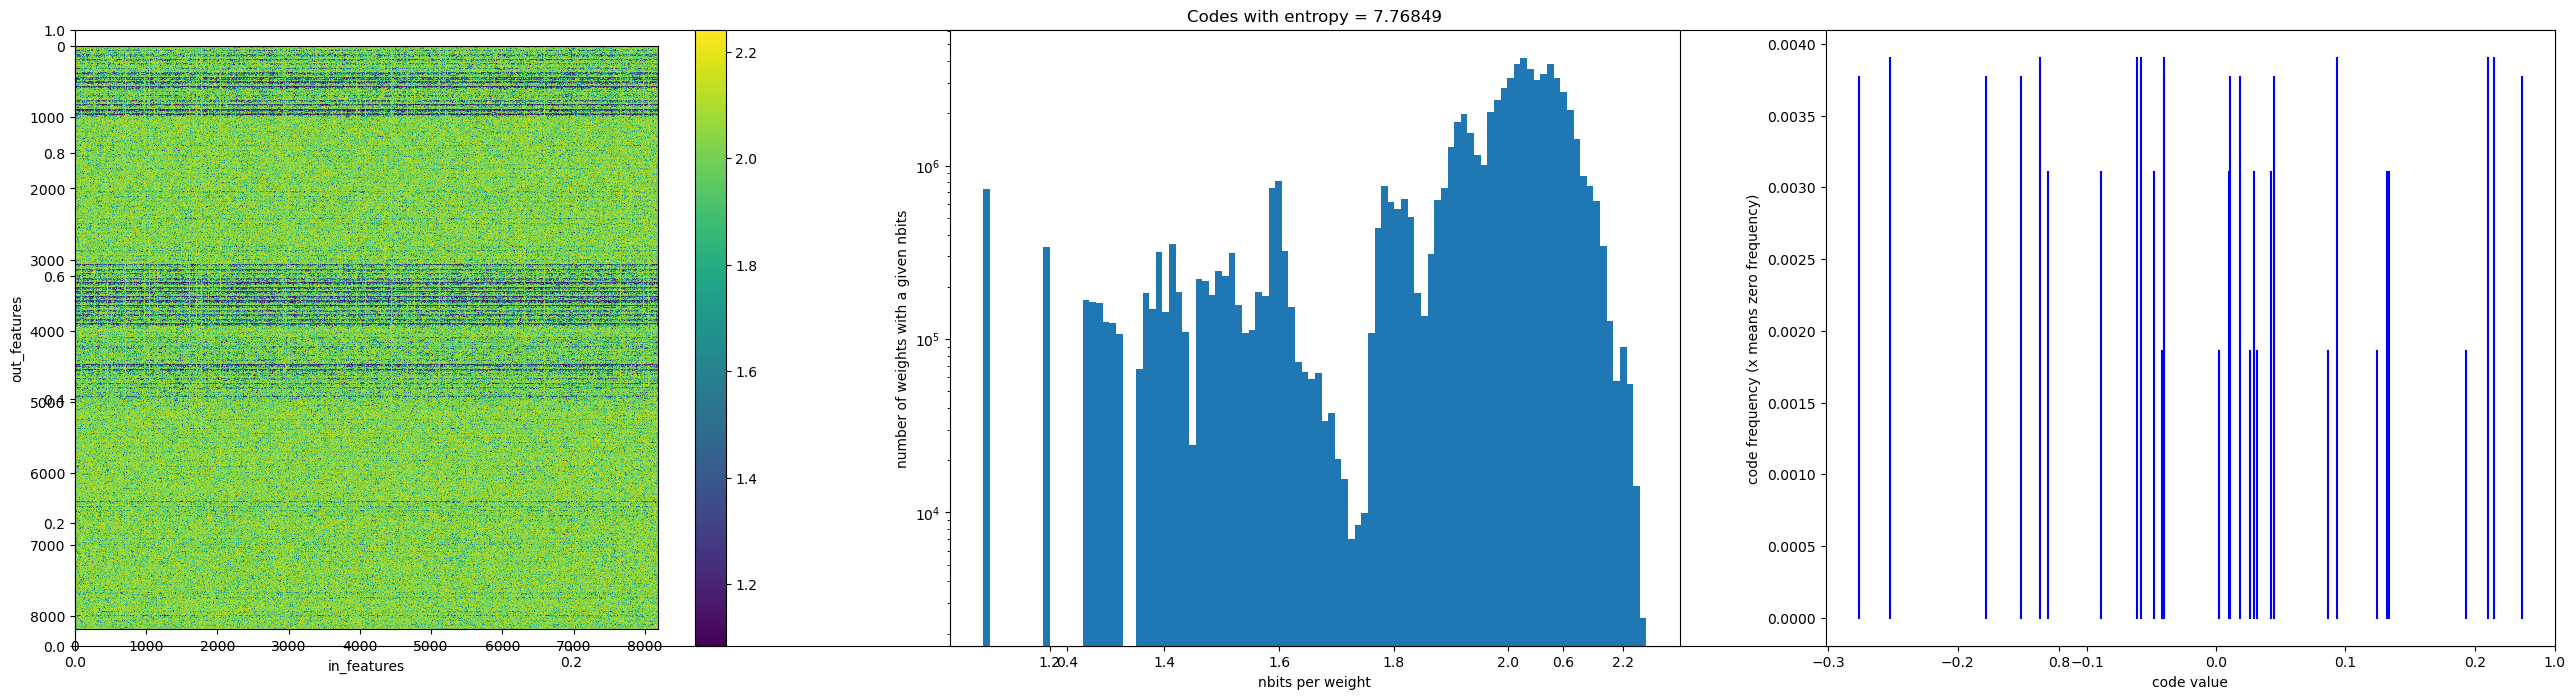

mean_code_nbits 7.79853
loss=0.0026678665	 time_on_epoch 300 = 0.18042585579678416
loss=0.0026624783	 time_on_epoch 310 = 0.14409883366897702
loss=0.0026580849	 time_on_epoch 320 = 0.1446820329874754
loss=0.0026542844	 time_on_epoch 330 = 0.14502293290570378
loss=0.0026509205	 time_on_epoch 340 = 0.14455086505040526
loss=0.0026478994	 time_on_epoch 350 = 0.14463479537516832
loss=0.0026451564	 time_on_epoch 360 = 0.14491923479363322
loss=0.0026426441	 time_on_epoch 370 = 0.14404277503490448
loss=0.0026403262	 time_on_epoch 380 = 0.14421859616413713
loss=0.0026381749	 time_on_epoch 390 = 0.14453599601984024
Entropy before beam search: 7.768490791320801


  0%|          | 0/2048 [00:00<?, ?it/s]

Entropy after beam search: 7.360659599304199
saved to /home/jheuristic/AQLM_entropy/notebooks/aq_entropy.pdf


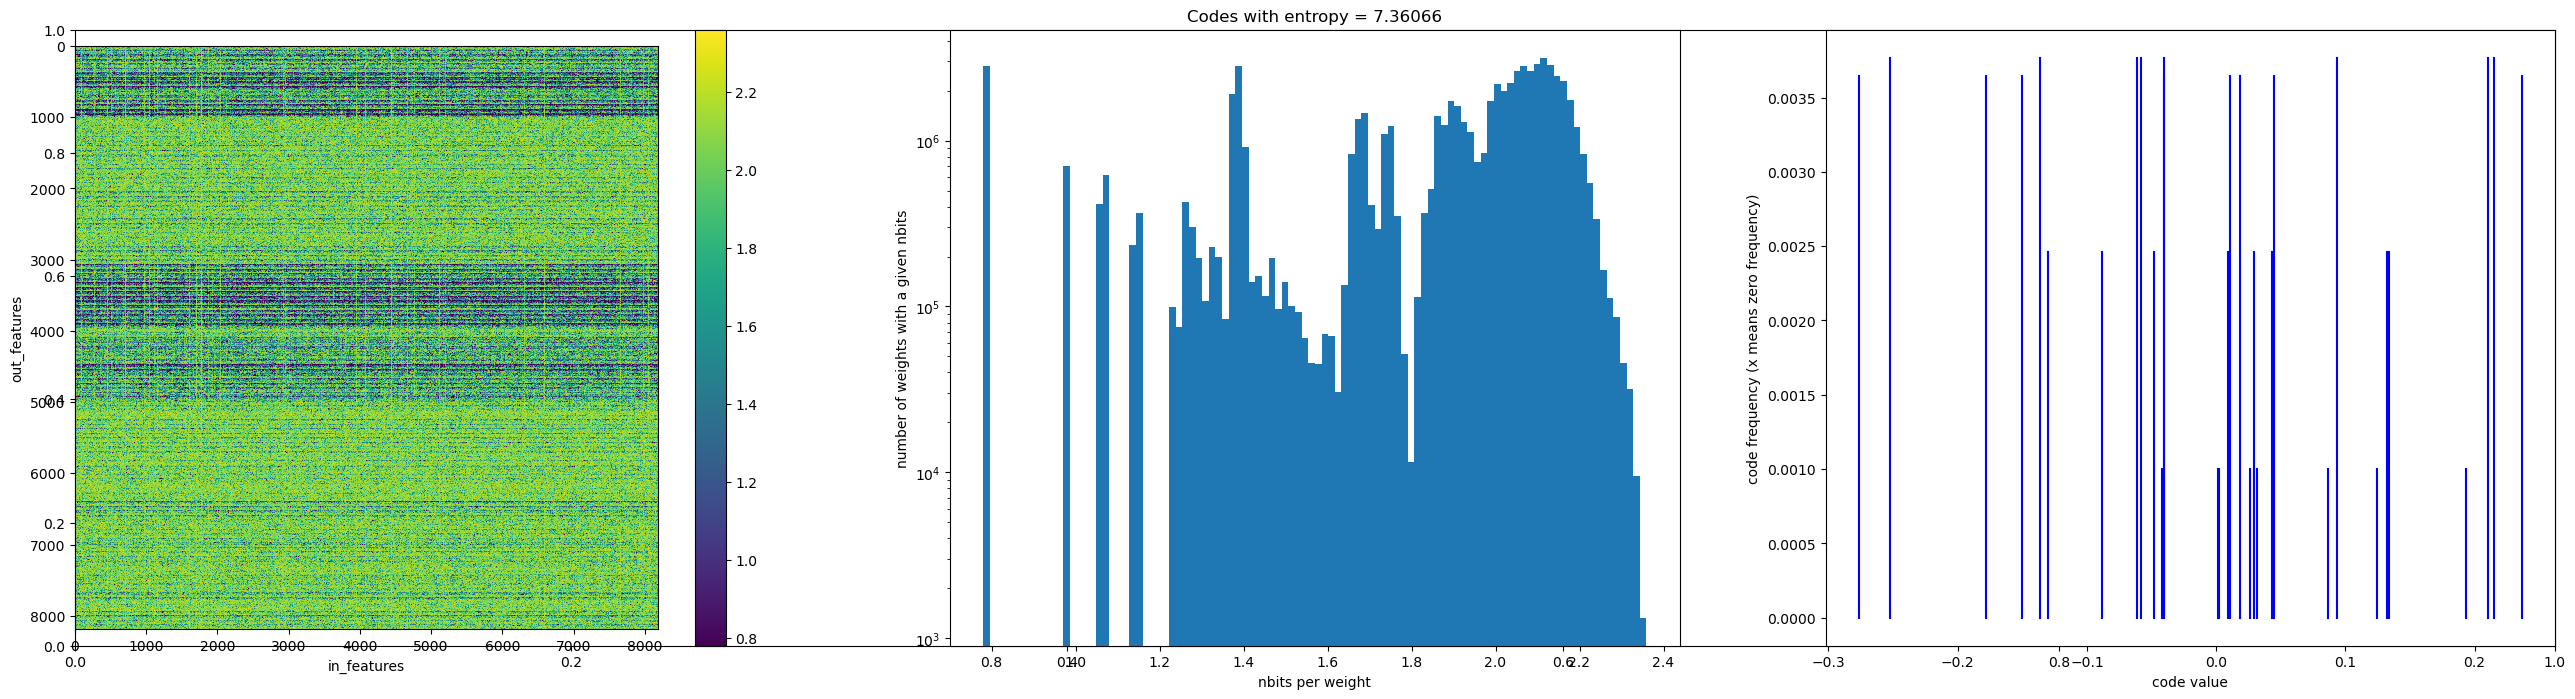

mean_code_nbits 7.39276
loss=0.0029502233	 time_on_epoch 400 = 0.1937831831164658
loss=0.0029414369	 time_on_epoch 410 = 0.15953877475112677
loss=0.0029347392	 time_on_epoch 420 = 0.1531735509634018
loss=0.0029290604	 time_on_epoch 430 = 0.1590818357653916
loss=0.0029240738	 time_on_epoch 440 = 0.15200638305395842
loss=0.0029196162	 time_on_epoch 450 = 0.15221938397735357
loss=0.0029155856	 time_on_epoch 460 = 0.15172666404396296
loss=0.0029119105	 time_on_epoch 470 = 0.1742721637710929
loss=0.0029085362	 time_on_epoch 480 = 0.15229461388662457
loss=0.0029054200	 time_on_epoch 490 = 0.15690815122798085
Entropy before beam search: 7.360659599304199


  0%|          | 0/2048 [00:00<?, ?it/s]

Entropy after beam search: 6.798980236053467
saved to /home/jheuristic/AQLM_entropy/notebooks/aq_entropy.pdf


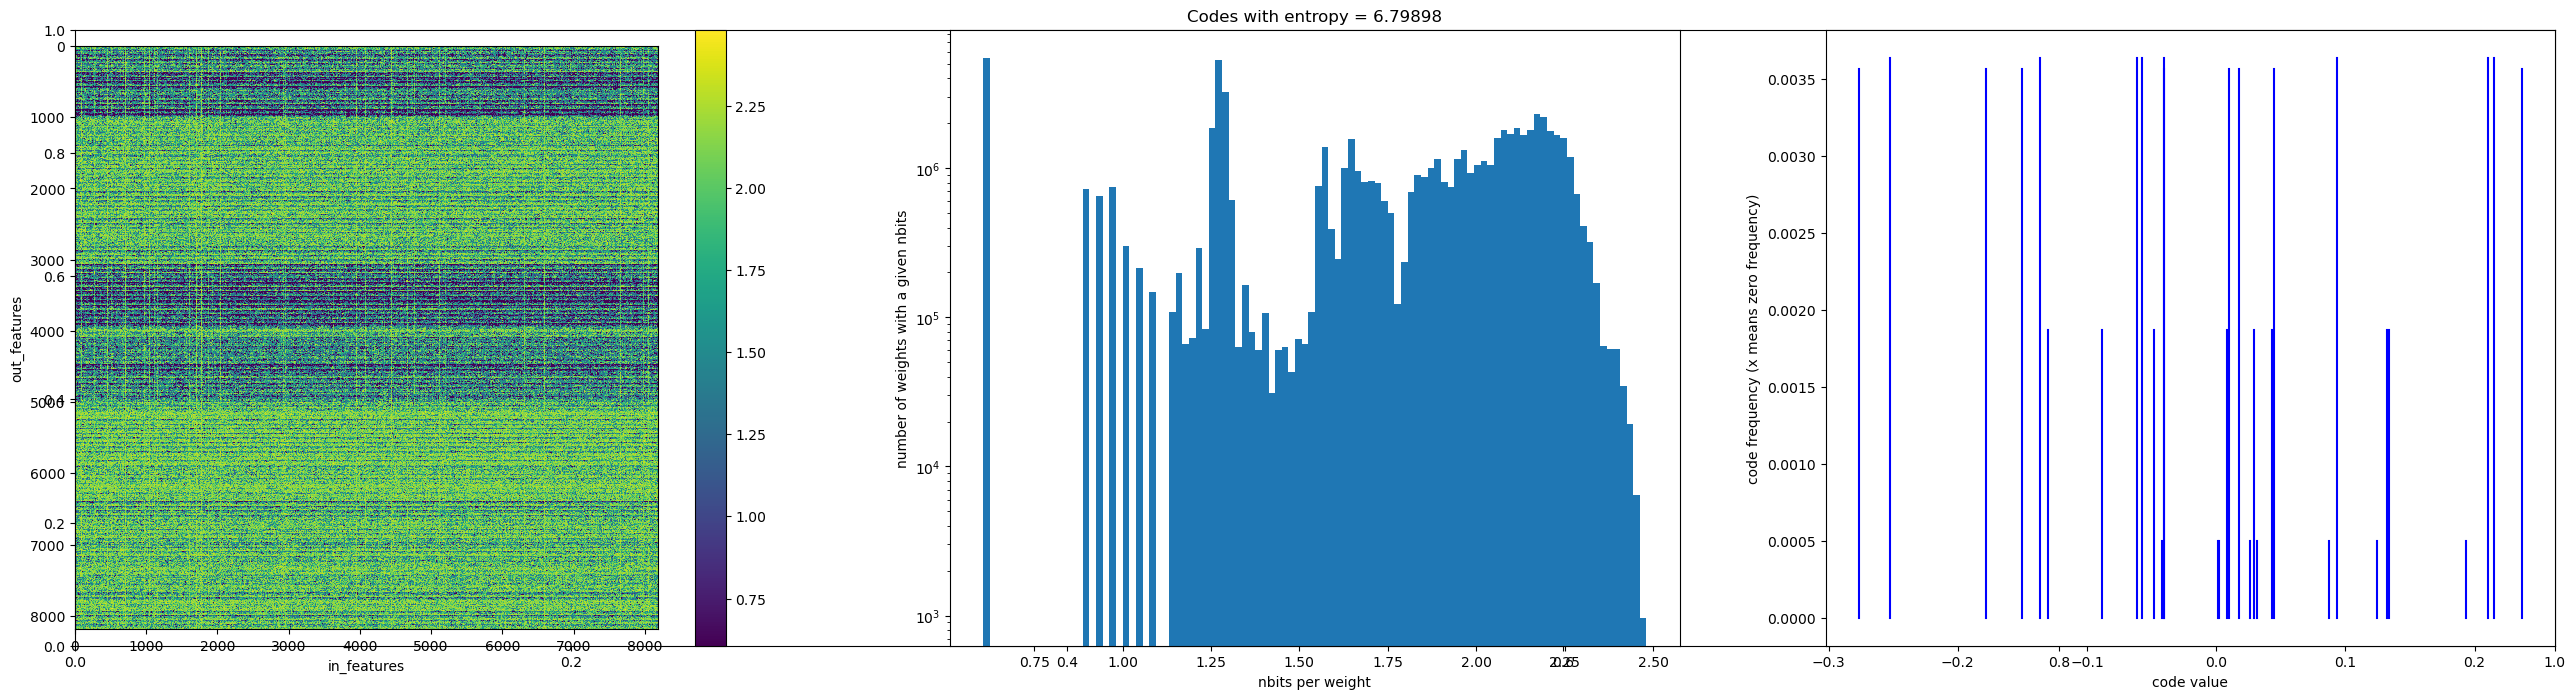

mean_code_nbits 6.83005
loss=0.0034730223	 time_on_epoch 500 = 0.1738308873027563
loss=0.0034586778	 time_on_epoch 510 = 0.16363662481307983
loss=0.0034483124	 time_on_epoch 520 = 0.16287034703418612
loss=0.0034396257	 time_on_epoch 530 = 0.16318701673299074
loss=0.0034320330	 time_on_epoch 540 = 0.16261088801547885
loss=0.0034252660	 time_on_epoch 550 = 0.162745398003608
loss=0.0034191640	 time_on_epoch 560 = 0.16334938816726208
loss=0.0034136158	 time_on_epoch 570 = 0.16338520776480436
loss=0.0034085362	 time_on_epoch 580 = 0.16351628908887506
loss=0.0034038588	 time_on_epoch 590 = 0.16359828878194094
Entropy before beam search: 6.798980236053467


  0%|          | 0/2048 [00:00<?, ?it/s]

Entropy after beam search: 6.343222618103027
saved to /home/jheuristic/AQLM_entropy/notebooks/aq_entropy.pdf


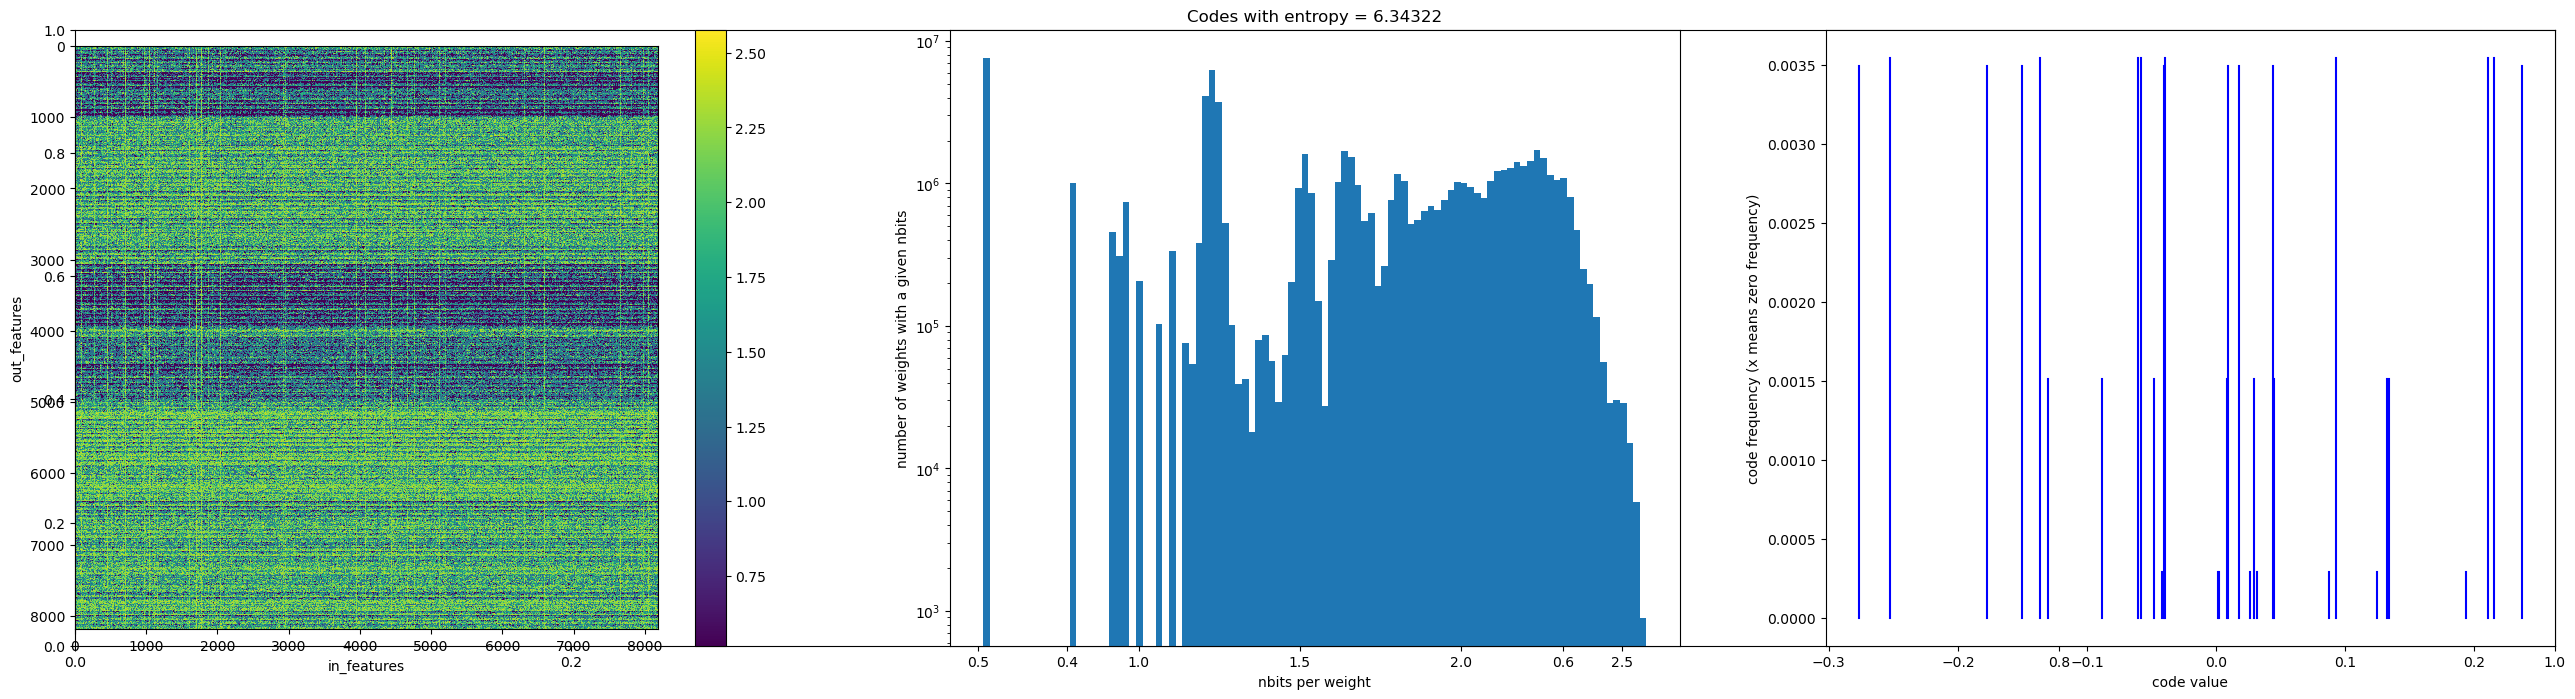

mean_code_nbits 6.38904
loss=0.0038902633	 time_on_epoch 600 = 0.186666757799685
loss=0.0038754783	 time_on_epoch 610 = 0.17055005067959428
loss=0.0038640115	 time_on_epoch 620 = 0.17115564085543156
loss=0.0038543089	 time_on_epoch 630 = 0.17113994201645255
loss=0.0038458019	 time_on_epoch 640 = 0.17136305198073387
loss=0.0038382137	 time_on_epoch 650 = 0.17128942208364606
loss=0.0038313732	 time_on_epoch 660 = 0.18998981872573495
loss=0.0038251565	 time_on_epoch 670 = 0.1721005029976368
loss=0.0038194696	 time_on_epoch 680 = 0.17111701285466552
loss=0.0038142388	 time_on_epoch 690 = 0.1705751554109156
Entropy before beam search: 6.343222618103027


  0%|          | 0/2048 [00:00<?, ?it/s]

In [ ]:
quantized_weight = QuantizedWeight(
    XTX=XTX, reference_weight=reference_weight, num_codebooks=num_codebooks,
    nbits_per_codebook=nbits_per_codebook, scale_nbits=scale_nbits, 
    out_group_size=out_group_size, in_group_size=in_group_size,
    scale_out_group_size=scale_out_group_size, scale_in_group_size=scale_in_group_size,
    verbose=True, max_iter=init_max_iter,   # faster init, not tested
)
run.log({"Avg_bits": quantized_weight.estimate_nbits_per_parameter()})
print("AVG bits:", quantized_weight.estimate_nbits_per_parameter())
opt = torch.optim.Adam(quantized_weight.parameters(), lr=1e-4, betas=(0.0, 0.95), amsgrad=True)


for epoch in range(1000):
    start = time.perf_counter()
    delta_weight = (quantized_weight() - reference_weight).double()
    loss = (delta_weight @ XTX.double()).flatten() @ delta_weight.flatten() / len(delta_weight)
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    run.log({'loss':loss.item()}, step=epoch)
    
    if epoch % print_frequency == 0:
        print(f"loss={loss.item():.10f}\t",
              f"time_on_epoch {epoch} = {time.perf_counter() - start}")
    if (epoch + 1) % beam_search_epochs == 0:
        print("Entropy before beam search:", _calculate_code_entropy(quantized_weight.codes).mean().item())
        code_penalties = _get_entropy_penalties_upper_bound(quantized_weight.codes, regularizer=info_regularizer)
        if epoch < info_warmup_epochs:   # hypothesis: this could help last codebooks become more meaningful before we prune them via entropy regularizer
            code_penalties *= 0
            print("Not regularizing for epoch", epoch)
        quantized_weight.beam_search_update_codes_(
            XTX, reference_weight, beam_size=beam_size, code_penalties=code_penalties,
            dim_rng=random.Random(), verbose=True)
        current_entropy = _calculate_code_entropy(quantized_weight.codes).mean().item()
        print("Entropy after beam search:", current_entropy)
        
        
        # drawing weight distribution; does not affect training
        freqs = _calculate_code_frequencies(quantized_weight.codes)
        code_nbits = -torch.log2(freqs.clamp_min(1e-18))
        codebook_range = torch.arange(num_codebooks)[None, None, :]
        weight_nbits = code_nbits[codebook_range, quantized_weight.codes].sum(-1).reshape(
            quantized_weight.codes.shape[0], 1, quantized_weight.codes.shape[1], 1
                ).tile(1, out_group_size, 1, in_group_size
                      ).reshape_as(reference_weight
                                  ).cpu().numpy() / (out_group_size * in_group_size)
        plt.figure(figsize=(32, 8))
        plt.title(f"Codes with entropy = {current_entropy:.5f}")
        plt.subplot(131)
        plt.imshow(weight_nbits, interpolation='none')
        plt.xlabel("in_features")
        plt.ylabel("out_features")
        plt.colorbar()
        plt.subplot(132)
        plt.hist(weight_nbits.ravel(), bins=100);
        plt.yscale('log')
        plt.xlabel('nbits per weight')
        plt.ylabel('number of weights with a given nbits')
        plt.subplot(133)
        code_values = quantized_weight.codebooks.detach().cpu().numpy()
        code_freqs = freqs.cpu().numpy()
        
        for codebook_index in range(num_codebooks):
            for i in range(len(code_freqs)):
                plt.plot([code_values[codebook_index, i].ravel()] * 2, [0, code_freqs[codebook_index, i]], color='blue', 
                         marker='' if code_freqs[codebook_index, i] > 0 else 'x', markersize=3)
            plt.xlabel("code value")
            plt.ylabel("code frequency (x means zero frequency)")
        pdf_fname = os.path.join(os.getcwd(), ipynbname.name() + '.pdf')
        plt.savefig(pdf_fname)
        print("saved to", pdf_fname)
        plt.show()
        
        mean_code_nbits = sum(get_mean_nbits_by_codebook(quantized_weight.codes, huffman_group_size=1)) / num_codebooks
        print(f"mean_code_nbits {mean_code_nbits:.5f}")
        run.log({'Mean codebook length nbits (huffman)': mean_code_nbits}, step=epoch)
        # drawing weight distribution; does not affect training



In [ ]:
import ctypes; ctypes.string_at(0)  # cause a jupyter notebook to hard-shutdown itself